<a href="https://www.kaggle.com/code/antongalysh/eda-image-classification?scriptVersionId=223379049" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Animal Classification

## Importing Required Libraries
This section imports necessary libraries such as NumPy, PyTorch, and PIL

In [1]:
import json
from collections import Counter
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torch.nn.functional as F
import PIL

## Loading animal dataset
Using torchvision to download and load the animal dataset. The dataset consists of animal images

In [2]:
dataset = datasets.ImageFolder(root='/kaggle/input/animal-image-classification-dataset/Training Data/Training Data')

## Image Analysis

### animal counts

- The dataset consists of **15 different animal classes**.
- The **number of images per class is balanced**, meaning that **class weighting in loss functions is not necessary**.

In [3]:
root = '/kaggle/input/animal-image-classification-dataset/Training Data/Training Data'

class_names = dataset.classes
class_counts = {label: 0 for label in class_names}

for label in class_names:
    folder = os.path.join(root, label)
    imgs = os.listdir(folder)

    class_counts[label] = len(imgs)


print(f"Number of classes: {len(class_names)}")

Number of classes: 15


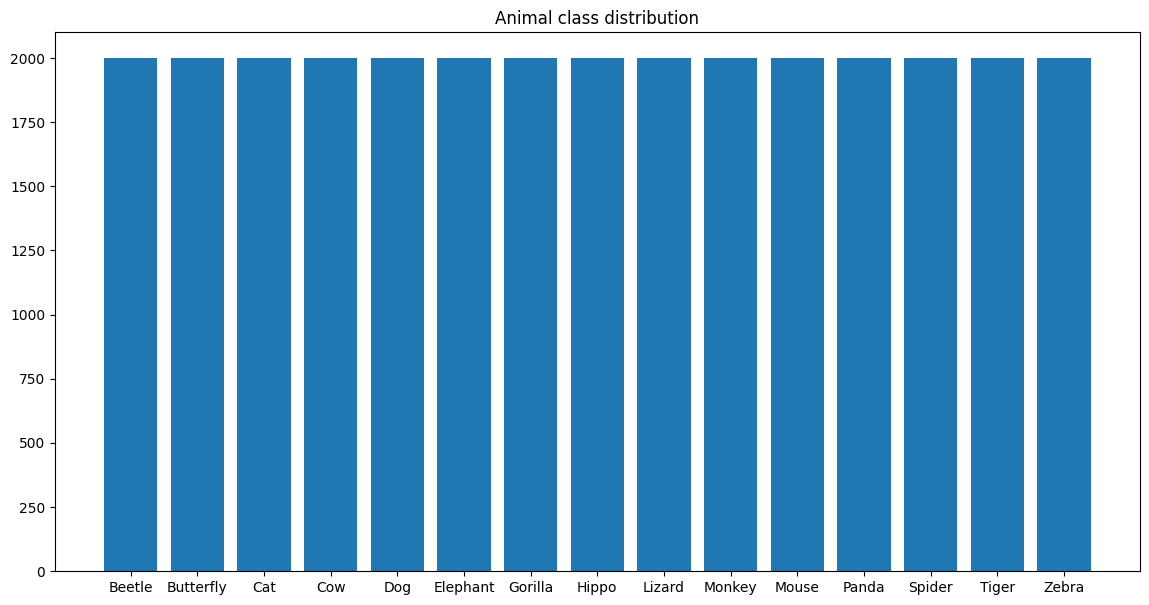

In [4]:
plt.figure(figsize=(14, 7))
plt.title("Animal class distribution")
plt.bar(range(len(class_counts)), list(class_counts.values()), align='center')
plt.xticks(range(len(class_counts)), list(class_counts.keys()))
plt.show()

### image example
- Sample images show that **images are clear** and **animals are centrally located**.
- This consistency helps in training models without additional preprocessing for object alignment.

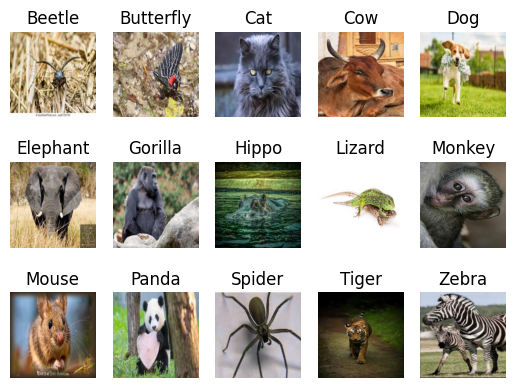

In [5]:
plt.tight_layout()

for i, label in enumerate(class_names, start=1):
    folder = os.path.join(root, label)
    img_file = os.listdir(folder)[0]

    img_path = os.path.join(folder, img_file)
    img = PIL.Image.open(img_path)

    plt.subplot(3, 5, i)
    plt.title(f"{label}")
    plt.axis('off')
    plt.imshow(img)


### image size distribution
- All images are of uniform size: **256x256 pixels**.
- To standardize input for the **VGG** model, we will apply **central cropping to 224x224 pixels**.
- This ensures a consistent input size while keeping the focus on the central subject.

Average width: 256.00
Average height: 256.00
Unique width: [256]
Unique height: [256]


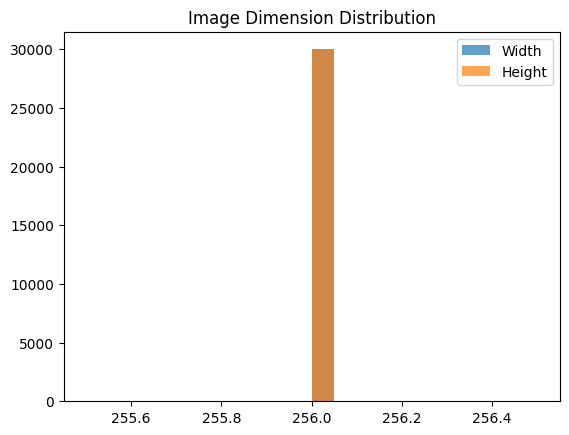

In [6]:
image_sizes = [img.size for img, y in dataset]
widths, heights = zip(*image_sizes)

print(f"Average width: {np.mean(widths):.2f}")
print(f"Average height: {np.mean(heights):.2f}")

print(f"Unique width: {np.unique(widths)}")
print(f"Unique height: {np.unique(heights)}")

plt.hist(widths, bins=20, alpha=0.7, label="Width")
plt.hist(heights, bins=20, alpha=0.7, label="Height")
plt.legend()
plt.title("Image Dimension Distribution")
plt.show()

## Animal Classifier: Model Structure & Implementation

### Image Transformer
The model utilizes an image transformation pipeline to ensure consistency in input data. The transformations include:
- **Resizing** images to 256x256.
- **Central Cropping** to 224x224.
- **Normalization** using dataset-specific mean and standard deviation.

### Model Architecture: VGG-Based Classifier
The model is based on **VGG19** pre-trained model: experiments showed that batch normalization is not needed bacause of a lot amount of classes. The key modifications include:
- **Freezing the pre-trained VGG19 layers** to retain pre-learned features.
- **Replacing the classifier layer** with a **dropout layer** followed by 2 fully connected layer.

The model automatically detects whether to run on **CUDA (GPU) or CPU**.

### training and prediction
1. **train(dataset)** -- add trainable classifier head to model depending on number ofclasses in dataset and train full model
2. **predict(X)** -- predict animal on PIL Image

In [7]:
class TransformDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]

        X_prep = self.transform(X)

        return X_prep, y


class AnimalClassifier:
    def __init__(self, **kwargs):
        """
        Initializes the AnimalClassifier model

        Args:
            epochs (int, optional): number of training epochs (default is 10)
            batch (int, optional): batch size for training (default is 32)
            lr (float, optional): learning rate for the optimizer (default is 1e-4)
        """
        super().__init__()

        self.model = self.__get_model()
        self.dropout = nn.Dropout(0.2)
        self.features_dim = self.model.classifier[0].in_features

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.epochs = kwargs.get('epochs', 20)
        self.batch_size = kwargs.get('batch', 256)
        self.lr = kwargs.get('lr', 1e-3)

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.3517, 0.3557, 0.3570],
                                 std=[0.2325, 0.2347, 0.2353])
        ])

        self.labels = None

    @ staticmethod
    def __get_model():
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT)

        for param in vgg.parameters():
            param.requires_grad = False

        return vgg

    def train(self, dataset):
        self.labels = dataset.classes
        self.model.classifier = nn.Sequential(
            self.dropout,
            nn.Linear(self.features_dim, 256),
            nn.ReLU(),
            nn.Linear(256, len(self.labels))
        )

        self.model = self.model.to(self.device)

        transform_dataset = TransformDataset(dataset, self.transform)
        dataloader = DataLoader(transform_dataset,
                                batch_size=self.batch_size,
                                shuffle=True
                                )

        loss_fn = nn.CrossEntropyLoss()
        
        optimizer = Adam(self.model.parameters(),
                         lr=self.lr
                         )

        losses = []

        self.model.train()
        for _ in range(self.epochs):
            loss_ = []
            for X_batch, y_batch in dataloader:
                y_batch = y_batch.to(self.device)
                X_batch = X_batch.to(self.device)

                y_pred = self.model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                loss_.append(loss.item())
            losses.append(np.mean(loss_))
            print(losses[-1])

        return losses

    def predict_proba(self, X):
        X_prep = self.transform(X)
        X_prep = X_prep.unsqueeze(dim=0)
        X_prep = X_prep.to(self.device)

        with torch.no_grad():
            logits = self.model(X_prep)
            y_pred = F.softmax(logits, dim=-1)

        return y_pred.cpu().numpy()

    def predict(self, X):
        probs = self.predict_proba(X)
        idx = probs.argmax(axis=-1)[0]

        try:
            return self.labels[idx]
        except Exception:
            raise Exception("model isn't trained")

    def save(self, model_path, labels_path):
        """
        Saves the trained model to a file

        Args:
            path (str): the file path where the model should be saved (default: 'nmnist_nn.pt')
        """
        with open(labels_path, 'w') as file:
            json.dump(self.labels, file)

        torch.save(self.model.state_dict(), model_path)

    def load(self, model_path, labels_path):
        with open(labels_path) as file:
            self.labels = json.load(file)

        self.model.classifier = nn.Sequential(
            self.dropout,
            nn.Linear(self.features_dim, 256),
            nn.Linear(256, len(self.labels))
        )

        weights = torch.load(model_path, weights_only=True)
        self.model.load_state_dict(weights)
        self.model = self.model.to(self.device)

## Animal Classifier Evaluation

The Animal Classifier model was evaluated on a diverse dataset of animal images, achieving an impressive **95.5% accuracy**.

### Key Observations:
- The model works exceptionally well across all animal categories, demonstrating its ability to identify a wide variety of species with high precision.
- It has been shown to classify animals from different environments, including both common and rare species, without significant performance degradation.
- While the model is highly accurate, performance can occasionally vary in cases where animals have visually similar characteristics, but these occurrences are rare.

### Conclusion:
The Animal Classifier model has proven to be highly reliable, achieving robust accuracy in identifying animals from a broad spectrum. With its high **95.5% accuracy**, it is well-suited for real-world applications where accurate animal classification is needed, making it a powerful tool for use in research, conservation, and other domains requiring animal identification.

In [8]:
from torch.utils.data import random_split

train_ratio = 0.8

train_data, test_data = random_split(dataset, [train_ratio, 1-train_ratio])

train_data.classes = dataset.classes
test_data.classes = dataset.classes

In [9]:
model = AnimalClassifier(epochs=10)
losses = model.train(train_data)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 217MB/s] 


0.3441463309399625
0.043575167755021696
0.011334701438751468
0.004974779664251478
0.0025633115679312975
0.002365291912165629
0.0013193458017145105
0.0026802747622454303
0.0038934678710536397
0.0021503582058667622


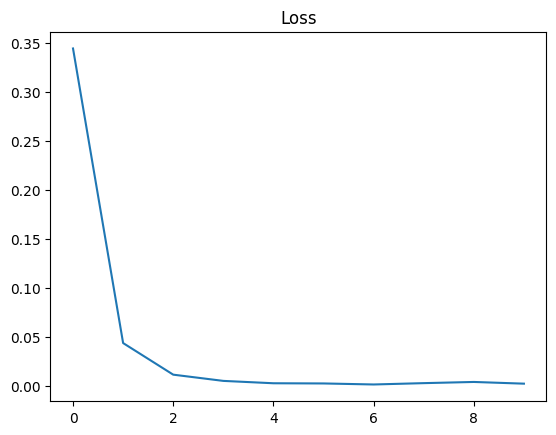

In [10]:
plt.title('Loss')
plt.plot(losses)

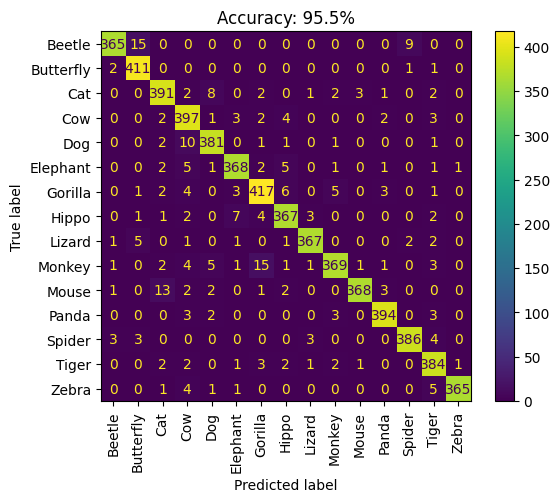

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score


y_pred = []
y_test = []

for img, label in test_data:
    idx = model.predict_proba(img).argmax(axis=-1)[0]

    y_test.append(label)
    y_pred.append(idx)

acc = accuracy_score(y_test, y_pred)*100
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=model.labels)
plt.xticks(rotation=90)
plt.title(f"Accuracy: {acc:.1f}%")
plt.show()

In [12]:
model.save('animal_classifier.pt', 'labels.json')